In [3]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.image as mpimg
from torch.utils.data import Dataset
from torchvision import transforms, utils
import torchvision.transforms as transforms
import cv2

from google.colab import drive
from google.colab.patches import cv2_imshow

%matplotlib inline

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#import a file from google drive
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/summercourse/d7/pca_poker_data//"
root_dir = '/content/drive/My Drive/summercourse/d7/'
root_ds = '/content/drive/My Drive/summercourse/d7/pca_poker_data/'

Mounted at /content/drive
testing  training


# Input

In [5]:
class PokerDataset(Dataset): 
    def __init__(self,root,train,transform): 
        self.transform = transform
        self.image_files = []
        if train:
            dic = 'training'
        else:
            dic = 'testing'
        for label in os.listdir(root+dic): 
            for r, _, f in os.walk(root+dic+'/'+label):
                for item in range(len(f)):
                    self.image_files.append((r+'/'+f[item],int(label)))

    def __getitem__(self, index):    
        img_name, label = self.image_files[index]
        img = mpimg.imread(img_name)
        img = transforms.ToTensor()(np.array(img))
        return[img,label]

    def __len__(self): 
        return len(self.image_files)
    
transform = transforms.Compose([transforms.ToTensor()])
img,label = PokerDataset(root_ds,True,transform).__getitem__(0)

print(type(img))
print(np.shape(img))
tempimg = np.zeros((96,71))
for i in range (96):
    for j in range (71):
        tempimg[i,j] = img[0,i,j]

<class 'torch.Tensor'>
torch.Size([1, 96, 71])


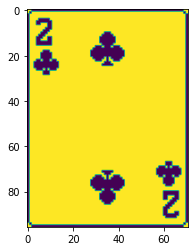

In [6]:
plt.figure()
plt.imshow(tempimg)
batchSize=13

In [7]:
print(type(img))
print(img)

<class 'torch.Tensor'>
tensor([[[1., 1., 0.,  ..., 0., 1., 1.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         [0., 1., 1.,  ..., 1., 1., 0.],
         ...,
         [0., 1., 1.,  ..., 1., 1., 0.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.]]])


In [8]:
trainset = PokerDataset(root_ds,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True)

testset = PokerDataset(root_ds,train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=True)

In [9]:
classes = ('0', '1', '2', '3')

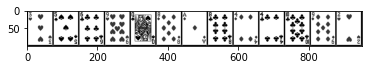

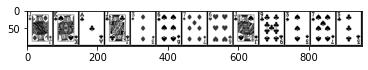

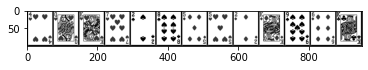

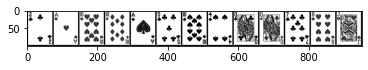

In [10]:
def show_batch(data):
    imgs = data[0]
    grid = utils.make_grid(imgs,nrow=batchSize)
#     print(grid.numpy().shape)
#     print(grid.numpy().transpose((1, 2, 0)).shape)

    plt.figure()
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('')

for i, data in enumerate(testloader):
    if(i<4):
        show_batch(data)
    else:
        break

# Net

# Loss and optimizer

# Training
https://www.runoob.com/python/python-func-enumerate.html

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

net = Net()

def train(model, num_epochs=5, batch_size=13, learning_rate=1e-3):
    torch.manual_seed(9)
    criterion = nn.CrossEntropyLoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--

    trainset = PokerDataset(root_ds,train=True,transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True)

    outputs = []
    for epoch in range(num_epochs):
        for data in trainloader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img) #issue detected
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

RuntimeError: ignored

In [42]:
img

tensor([[[1., 1., 0.,  ..., 0., 1., 1.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         [0., 1., 1.,  ..., 1., 1., 0.],
         ...,
         [0., 1., 1.,  ..., 1., 1., 0.],
         [1., 0., 1.,  ..., 1., 0., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.]]])

# Save Weight

In [14]:
w_path = './w_poker_net.pth'
m_path = './m_poker_net.pth'
torch.save(net.state_dict(), w_path)
torch.save(net, m_path)

# Load Weight

In [ ]:
net = Net()
net.load_state_dict(torch.load(w_path))

<All keys matched successfully>

# Testing
https://www.runoob.com/python/python-func-iter.html
torch.max(input, dim, keepdim=False, out=None)

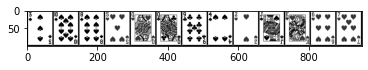

In [ ]:
dataiter = iter(testloader)
data = dataiter.next()
images, labels = data
show_batch(data)

In [ ]:
outputs = net(images)
outputs.size()

torch.Size([13, 4])

In [ ]:
_, predicted = torch.max(outputs, 1)
print(_)
print(predicted)

tensor([0.5721, 0.5597, 0.5478, 0.5696, 0.5416, 0.5179, 0.5726, 0.5512, 0.6046,
        0.5561, 0.5527, 0.5589, 0.5703], grad_fn=<MaxBackward0>)
tensor([1, 3, 3, 1, 1, 1, 0, 1, 1, 3, 2, 1, 1])


In [ ]:
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(13)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(13)))

GroundTruth:      3     3     3     2     2     0     0     3     2     3     2     2     2
Predicted:      1     3     3     1     1     1     0     1     1     3     2     1     1


In [ ]:
correct = 0
total = 52
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)      
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


In [ ]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))